In [1]:
import latentvelo as ltv
import scanpy as sc
import scvelo as scv
import numpy as np
import torch as th
import anndata as ad

Global seed set to 0


In [2]:
adata = sc.read('../synthetic_datasets/synthetic_binary_tree_5000.h5ad')
adata.layers['rna_velocity'] = np.array(adata.layers['rna_velocity'].todense())

milestones = adata.uns['traj_progressions']['from'].values + '->' + adata.uns['traj_progressions']['to'].values

for i in range(len(milestones)):
    if milestones[i] == 'sA->sB' or milestones[i] == 'sB->sC' or milestones[i] == 'sC->sCmid':
        milestones[i] = 'A'
    elif milestones[i] == 'sCmid->sE':
        milestones[i] = 'B'
    elif milestones[i] == 'sE->sEndE':
        milestones[i] = 'C'
    elif milestones[i] == 'sCmid->sD' or milestones[i] == 'sD->sDmid':
        milestones[i] = 'D'
    elif milestones[i] == 'sDmid->sF': 
        milestones[i] = 'E'
    elif milestones[i] == 'sDmid->sG':
        milestones[i] = 'F'
    elif milestones[i] == 'sG->sEndG':
        milestones[i] = 'G'
    elif milestones[i] == 'sF->sEndF':
        milestones[i] = 'H'

adata.obs['milestone'] = milestones

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


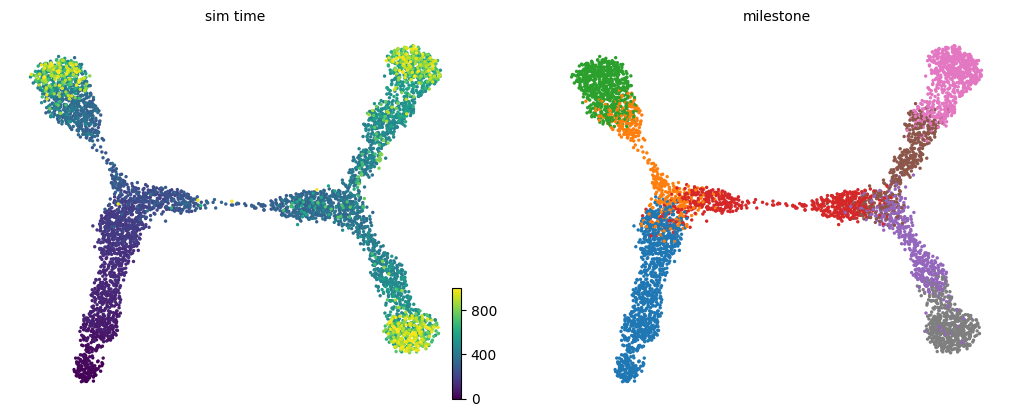

In [3]:
ltv.utils.standard_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 umap=True)
scv.pl.umap(adata, color=['sim_time', 'milestone'])

In [4]:
model = ltv.models.VAE(observed=89, latent_dim=20, zr_dim=2, h_dim=3)

In [5]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=25, name='binary_tree', grad_clip=100)

32 velocity genes used
epoch 0, full loss 148.483, val loss 55.028, recon MSE 2.174, traj MSE 0.455, reg loss -2.477
epoch 1, full loss 76.155, val loss 10.607, recon MSE 1.957, traj MSE 0.426, reg loss -2.754
epoch 2, full loss 68.267, val loss -29.706, recon MSE 1.455, traj MSE 0.345, reg loss -2.949
epoch 3, full loss 103.690, val loss -68.492, recon MSE 1.099, traj MSE 0.322, reg loss -3.226
epoch 4, full loss 178.201, val loss -98.452, recon MSE 0.966, traj MSE 0.295, reg loss -1.862
epoch 5, full loss 199.479, val loss -114.833, recon MSE 0.784, traj MSE 0.286, reg loss -2.040
epoch 6, full loss 255.574, val loss -124.002, recon MSE 0.746, traj MSE 0.307, reg loss -2.119
epoch 7, full loss 250.271, val loss -126.154, recon MSE 0.635, traj MSE 0.287, reg loss -2.165
epoch 8, full loss 279.642, val loss -127.842, recon MSE 0.584, traj MSE 0.294, reg loss -2.245
epoch 9, full loss 274.508, val loss -126.054, recon MSE 0.525, traj MSE 0.286, reg loss -2.268
epoch 10, full loss 294.18

computing velocity graph (using 12/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


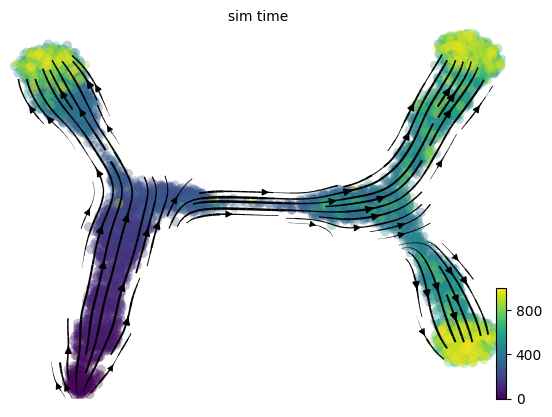

In [6]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', n_jobs=12)
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='sim_time')

# Perform benchmark

In [7]:
adata.layers['gene_velocity'] = adata.layers['velo'].copy()

cluster_edges = [('A', 'B'), ('B', 'C'),
                 ('A', 'D'),
                 ('D', 'E'),('E','H'),
                 ('D', 'F'), ('F', 'G')]


ltv.ev.format_benchmark_adata(adata, latent_adata, estimated_vkey='spliced_velocity')
results = ltv.ev.benchmark_synthetic(adata, estimated_vkey='gene_velocity', 
                                      sim_vkey='rna_velocity', 
                                      basis_list=['','latent','pca','pca_10', 'pca_3','umap'],
                                      cluster_edges = cluster_edges, cluster_key='milestone', avg_velocity=True)

adata.write('../benchmark/synthetic_trajectories/fits/binary_tree_adata.h5ad')
latent_adata.write('../benchmark/synthetic_trajectories/fits/binary_tree_latent_adata.h5ad')
results.to_csv('../benchmark/synthetic_trajectories/fits/binary_tree_results_df.csv')

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'rna_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_latent', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:02) --> added
    'rna_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_umap', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.